In [1]:
# =============================================================================
# Cell 1: Import Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt_tab')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# =============================================================================
# Cell 2: Load Data
# =============================================================================

# Load original data
df = pd.read_csv('../src/data/raw/temu_reviews.csv')

# Load processed data
with open('../src/models/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

print("Data loaded successfully!")
print(f"Original data shape: {df.shape}")

# Prepare text data for topic modeling
df['ReviewText'] = df['ReviewText'].fillna('')
df['ReviewTitle'] = df['ReviewTitle'].fillna('')
df['CombinedText'] = df['ReviewTitle'] + ' ' + df['ReviewText']

# Add features from processed data
df['ReviewLength'] = df['ReviewText'].str.len()
df['WordCount'] = df['ReviewText'].str.split().str.len()

print(f"Text data prepared for analysis")

Data loaded successfully!
Original data shape: (13855, 11)
Text data prepared for analysis


In [3]:
# =============================================================================
# Cell 3: Advanced Text Preprocessing for Topic Modeling
# =============================================================================

print("="*50)
print("ADVANCED TEXT PREPROCESSING FOR TOPIC MODELING")
print("="*50)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to e-commerce reviews
custom_stopwords = {'product', 'item', 'order', 'delivery', 'shipping', 'package', 
                   'received', 'bought', 'purchase', 'customer', 'service', 'temu',
                   'quality', 'price', 'good', 'bad', 'great', 'terrible', 'nice',
                   'recommend', 'would', 'could', 'should', 'one', 'two', 'three',
                   'get', 'got', 'go', 'come', 'time', 'day', 'week', 'month'}
stop_words.update(custom_stopwords)

def preprocess_text_for_topics(text):
    """
    Advanced text preprocessing for topic modeling
    This function is important because:
    1. It removes noise from text data
    2. It normalizes words to their root forms
    3. It removes common words that don't add meaning
    """
    if pd.isna(text):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, emails, and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text for topic modeling...")
df['ProcessedText'] = df['CombinedText'].apply(preprocess_text_for_topics)

# Remove empty texts
df = df[df['ProcessedText'].str.len() > 0]
print(f"After preprocessing: {len(df)} reviews remaining")

ADVANCED TEXT PREPROCESSING FOR TOPIC MODELING
Preprocessing text for topic modeling...
After preprocessing: 13840 reviews remaining


In [4]:
# =============================================================================
# Cell 4: Topic Modeling with Latent Dirichlet Allocation (LDA)
# =============================================================================

print("\n" + "="*50)
print("TOPIC MODELING WITH LDA")
print("="*50)

# Why LDA for topic modeling?
print("Why use LDA for topic modeling:")
print("1. Discovers hidden topics in customer reviews")
print("2. Identifies common complaint and praise categories")
print("3. Helps understand customer concerns")
print("4. Provides interpretable topic distributions")

# Create TF-IDF vectors for topic modeling
vectorizer = TfidfVectorizer(
    max_features=1000,
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 2),
    stop_words='english'
)

tfidf_matrix = vectorizer.fit_transform(df['ProcessedText'])
feature_names = vectorizer.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(feature_names)}")

# Train LDA model
print("\nTraining LDA model...")
n_topics = 8  # We'll try 8 topics to capture diverse themes

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,
    learning_method='online',
    learning_offset=50.0
)

lda_model.fit(tfidf_matrix)
print("LDA model trained successfully!")


TOPIC MODELING WITH LDA
Why use LDA for topic modeling:
1. Discovers hidden topics in customer reviews
2. Identifies common complaint and praise categories
3. Helps understand customer concerns
4. Provides interpretable topic distributions
TF-IDF matrix shape: (13840, 1000)
Number of features: 1000

Training LDA model...
LDA model trained successfully!


In [5]:
# =============================================================================
# Cell 5: Topic Analysis and Interpretation
# =============================================================================

print("\n" + "="*50)
print("TOPIC ANALYSIS AND INTERPRETATION")
print("="*50)

# Get topic distributions
topic_distributions = lda_model.transform(tfidf_matrix)
df['DominantTopic'] = topic_distributions.argmax(axis=1)
df['TopicProbability'] = topic_distributions.max(axis=1)

# Display top words for each topic
def display_topics(model, feature_names, num_top_words=10):
    """
    This function extracts and displays the most important words for each topic
    """
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-num_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[topic_idx] = top_words
    return topics

topics = display_topics(lda_model, feature_names)

print("Discovered Topics:")
print("-" * 40)
topic_labels = [
    "Shipping & Delivery",
    "Product Quality", 
    "Customer Service",
    "Price & Value",
    "Clothing & Sizing",
    "Electronics",
    "Returns & Refunds",
    "Overall Experience"
]

for topic_id, words in topics.items():
    label = topic_labels[topic_id] if topic_id < len(topic_labels) else f"Topic {topic_id}"
    print(f"{label}: {', '.join(words)}")

# Topic distribution in dataset
topic_counts = df['DominantTopic'].value_counts().sort_index()
print(f"\nTopic Distribution in Dataset:")
print("-" * 35)
for topic_id, count in topic_counts.items():
    percentage = (count / len(df)) * 100
    label = topic_labels[topic_id] if topic_id < len(topic_labels) else f"Topic {topic_id}"
    print(f"{label}: {count:,} reviews ({percentage:.1f}%)")


TOPIC ANALYSIS AND INTERPRETATION
Discovered Topics:
----------------------------------------
Shipping & Delivery: free, gift, scam, app, game, free gift, dont, item, offer, spend
Product Quality: refund, item, company, delivered, ordered, dont, return, money, parcel, email
Customer Service: card, bank, credit, credit card, account, charged, bank account, payment, garbage, charge
Price & Value: shoe, pair, size, cover, ordered, boot, wrong size, tax, item item, wrong
Clothing & Sizing: item, ordered, love, ive, price, product, happy, thing, order, like
Electronics: cheap, product, poor, rubbish, buy, worst, crap, company, junk, waste money
Returns & Refunds: fast, absolute, thanks, water, super, shopped, quick, thank, tool, rubbish
Overall Experience: mail, ad, spam, hate, royal, advertisement, royal mail, advert, annoying, morning

Topic Distribution in Dataset:
-----------------------------------
Shipping & Delivery: 1,948 reviews (14.1%)
Product Quality: 5,677 reviews (41.0%)
Custo


TOPIC VISUALIZATION


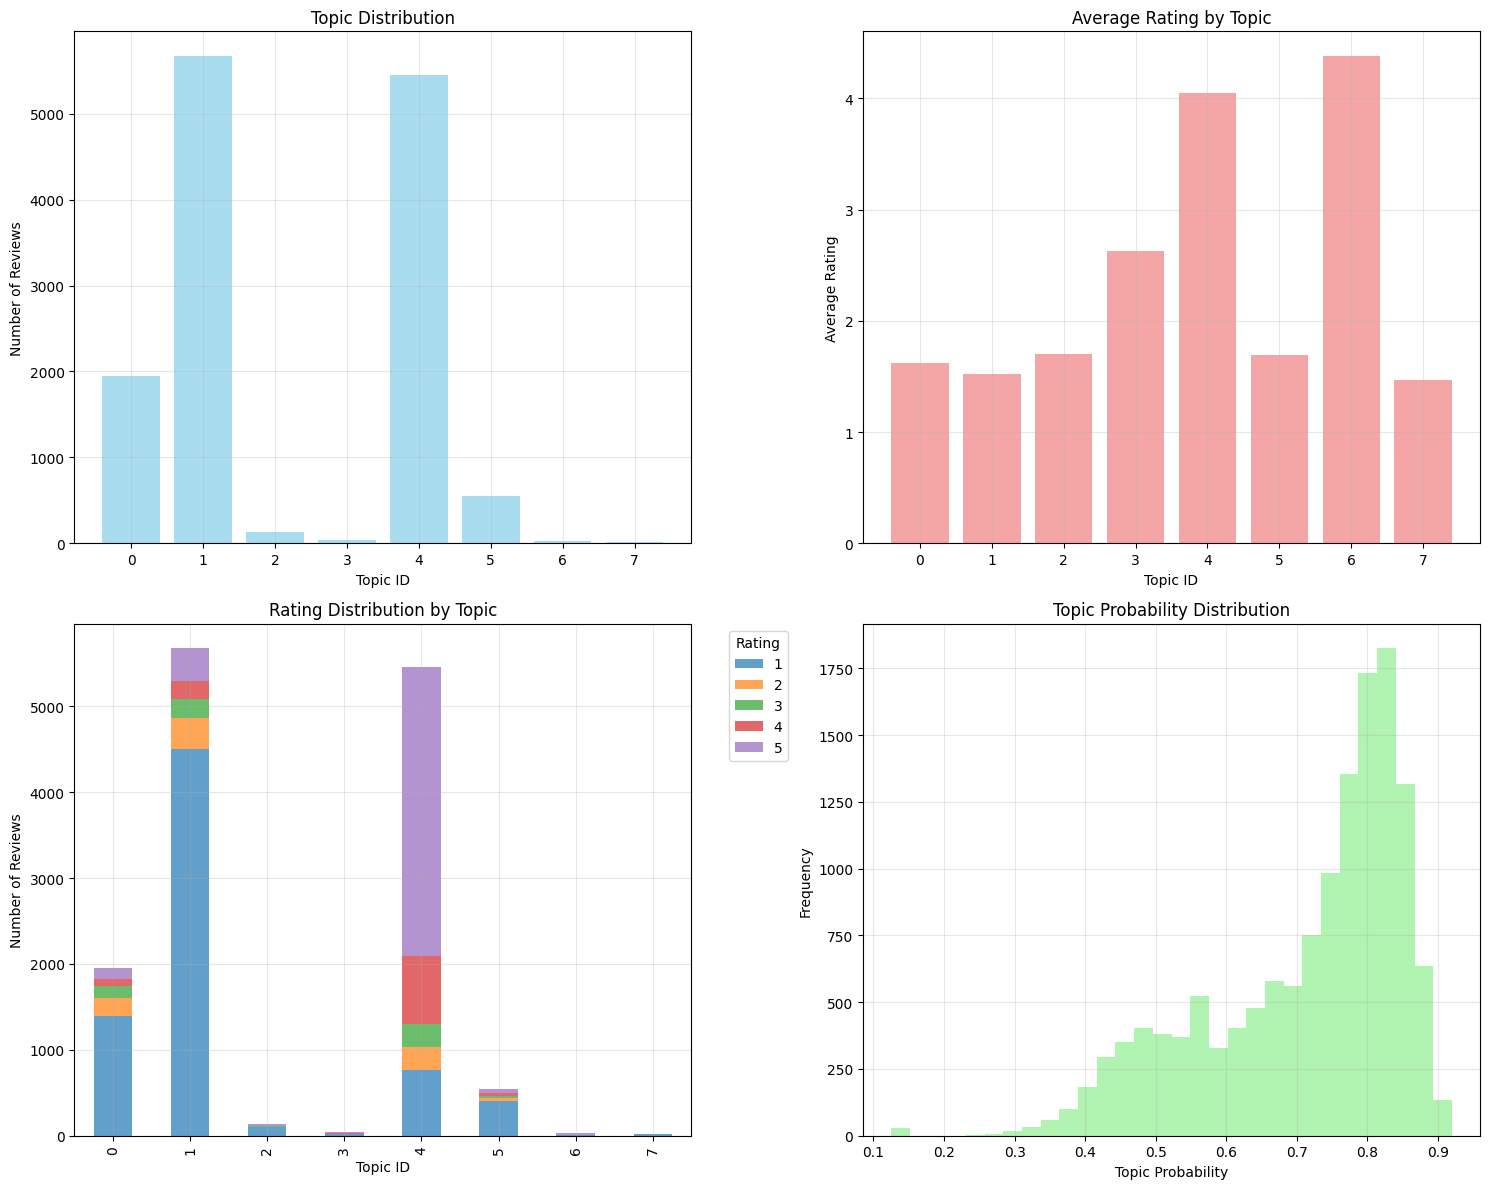

In [6]:
# =============================================================================
# Cell 6: Topic Visualization
# =============================================================================

print("\n" + "="*50)
print("TOPIC VISUALIZATION")
print("="*50)

# Create visualizations for topics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Topic distribution
axes[0, 0].bar(topic_counts.index, topic_counts.values, color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel('Topic ID')
axes[0, 0].set_ylabel('Number of Reviews')
axes[0, 0].set_title('Topic Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Average rating by topic
topic_ratings = df.groupby('DominantTopic')['ReviewRating'].mean()
axes[0, 1].bar(topic_ratings.index, topic_ratings.values, color='lightcoral', alpha=0.7)
axes[0, 1].set_xlabel('Topic ID')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_title('Average Rating by Topic')
axes[0, 1].grid(True, alpha=0.3)

# Rating distribution by topic
topic_rating_dist = df.groupby(['DominantTopic', 'ReviewRating']).size().unstack(fill_value=0)
topic_rating_dist.plot(kind='bar', stacked=True, ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_xlabel('Topic ID')
axes[1, 0].set_ylabel('Number of Reviews')
axes[1, 0].set_title('Rating Distribution by Topic')
axes[1, 0].legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Topic probability distribution
axes[1, 1].hist(df['TopicProbability'], bins=30, alpha=0.7, color='lightgreen')
axes[1, 1].set_xlabel('Topic Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Topic Probability Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TOPIC WORD CLOUDS


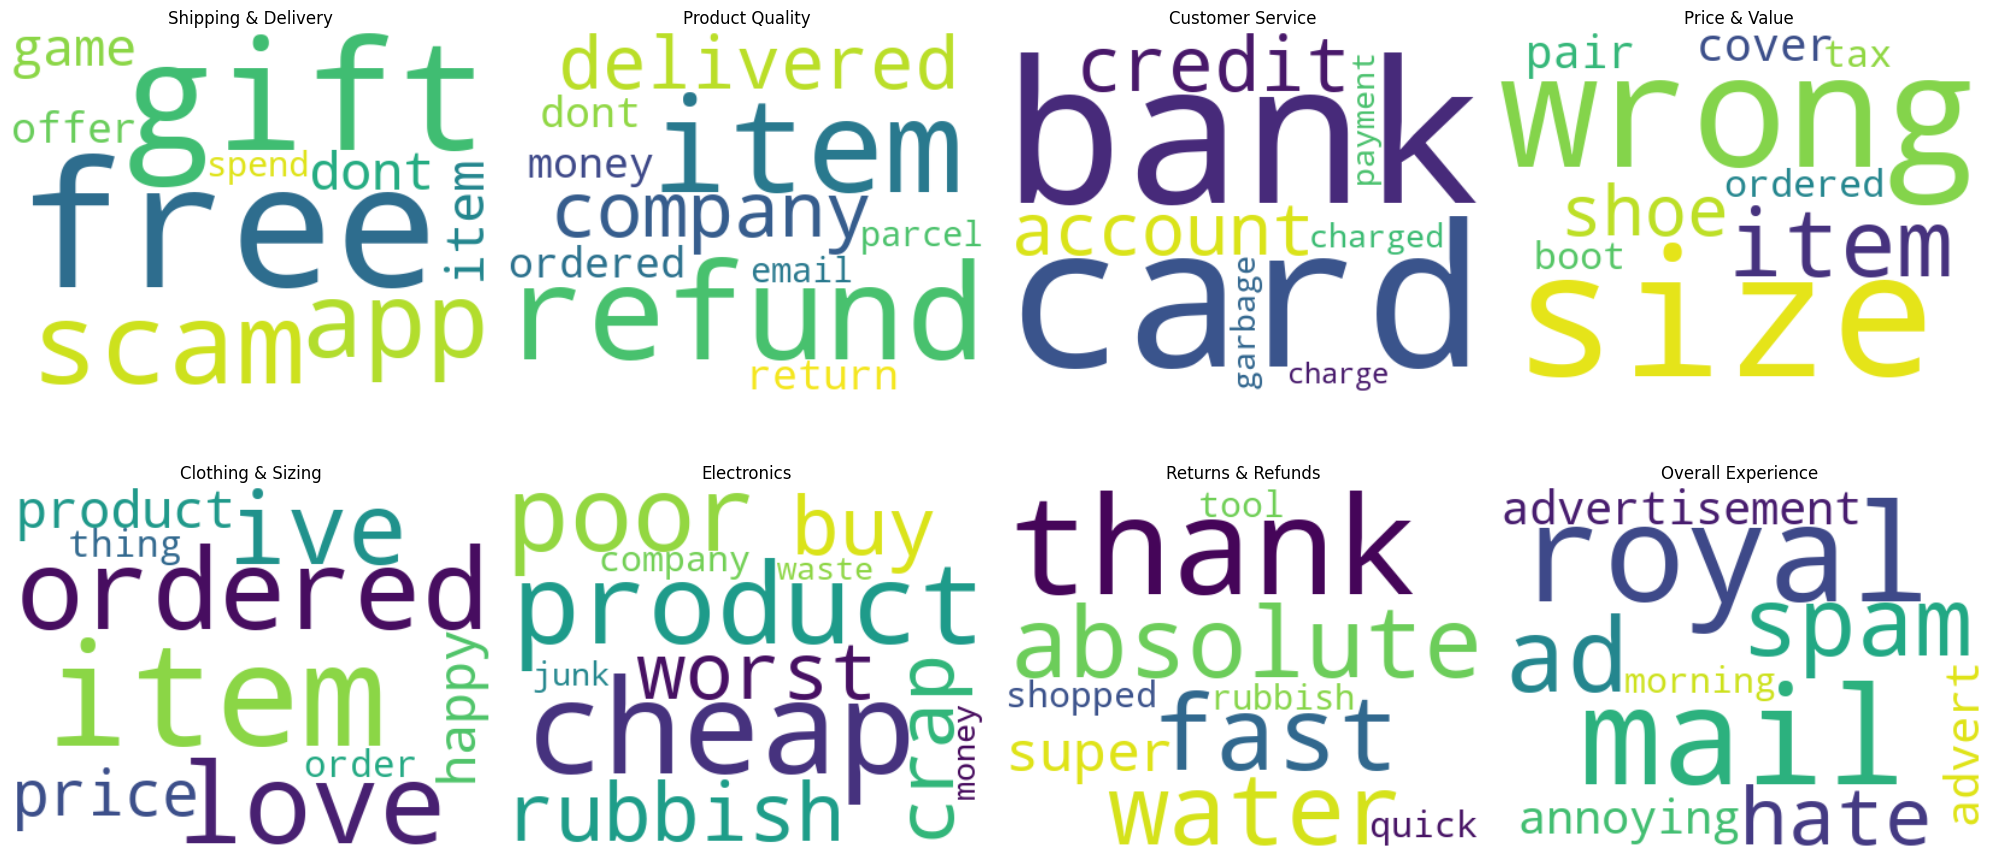

In [7]:
# =============================================================================
# Cell 7: Generate Word Clouds for Topics
# =============================================================================

print("\n" + "="*50)
print("TOPIC WORD CLOUDS")
print("="*50)

# Create word clouds for each topic
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for topic_id in range(n_topics):
    # Get top words for this topic
    topic_words = topics[topic_id]
    
    # Create word cloud
    wordcloud = WordCloud(
        width=400, 
        height=300,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate(' '.join(topic_words))
    
    label = topic_labels[topic_id] if topic_id < len(topic_labels) else f"Topic {topic_id}"
    axes[topic_id].imshow(wordcloud, interpolation='bilinear')
    axes[topic_id].set_title(f'{label}', fontsize=12)
    axes[topic_id].axis('off')

plt.tight_layout()
plt.show()


In [8]:
# =============================================================================
# Cell 8: Customer Classification Analysis
# =============================================================================

print("\n" + "="*60)
print("CUSTOMER CLASSIFICATION ANALYSIS")
print("="*60)

# Why customer classification?
print("Why classify customers:")
print("1. Identify frequent vs. occasional reviewers")
print("2. Distinguish constructive vs. aggressive reviewers")
print("3. Find loyal customers through linguistic patterns")
print("4. Personalize customer service approach")

# Create customer features
customer_features = df.groupby('UserId').agg({
    'ReviewRating': ['mean', 'std', 'count'],
    'ReviewLength': 'mean',
    'WordCount': 'mean',
    'TopicProbability': 'mean',
    'ReviewDate': ['min', 'max']
}).reset_index()

# Flatten column names
customer_features.columns = ['UserId', 'avg_rating', 'rating_std', 'review_count',
                           'avg_review_length', 'avg_word_count', 'avg_topic_prob',
                           'first_review', 'last_review']

# Calculate customer tenure
customer_features['tenure_days'] = (
    pd.to_datetime(customer_features['last_review']) - 
    pd.to_datetime(customer_features['first_review'])
).dt.days + 1

# Fill NaN values
customer_features['rating_std'] = customer_features['rating_std'].fillna(0)

print(f"Customer features created for {len(customer_features)} unique customers")


CUSTOMER CLASSIFICATION ANALYSIS
Why classify customers:
1. Identify frequent vs. occasional reviewers
2. Distinguish constructive vs. aggressive reviewers
3. Find loyal customers through linguistic patterns
4. Personalize customer service approach
Customer features created for 13839 unique customers


In [10]:
# =============================================================================
# Cell 9: Customer Sentiment Analysis
# =============================================================================

print("\n" + "="*50)
print("CUSTOMER SENTIMENT ANALYSIS")
print("="*50)

df_proc = processed_data["df"] if isinstance(processed_data, dict) else processed_data

# Analyze sentiment patterns by customer
customer_sentiment = (
    df_proc.groupby("UserId")["sentiment_compound"]
           .agg(["mean", "std"])
           .reset_index()
           .rename(columns={"mean": "avg_sentiment", "std": "sentiment_std"})
)
customer_sentiment["sentiment_std"].fillna(0, inplace=True)

# Merge customer sentiment with customer features
customer_features = customer_features.merge(customer_sentiment, on="UserId", how="left")
print("Customer sentiment features added successfully")


CUSTOMER SENTIMENT ANALYSIS
Customer sentiment features added successfully



CUSTOMER CLUSTERING
Determining optimal number of clusters...


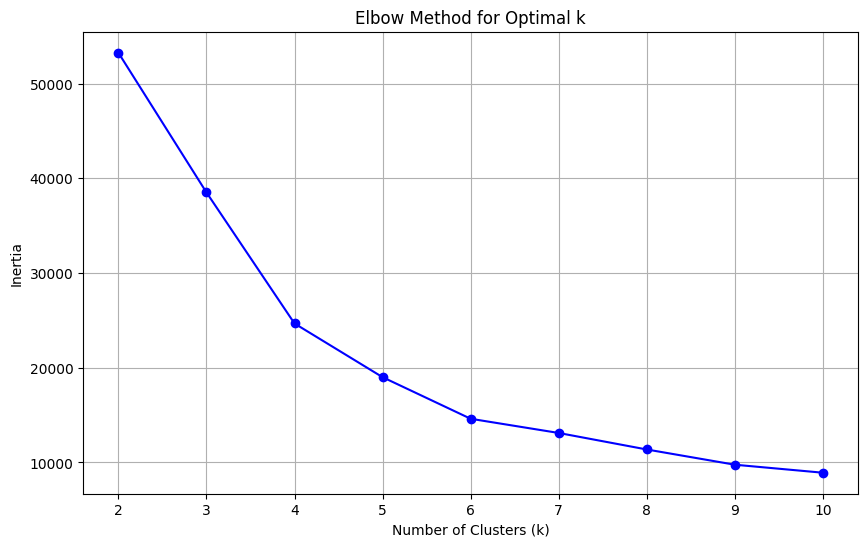

Customers clustered into 5 groups


In [11]:
# =============================================================================
# Cell 10: Customer Clustering
# =============================================================================

print("\n" + "="*50)
print("CUSTOMER CLUSTERING")
print("="*50)

# Select features for clustering
clustering_features = ['avg_rating', 'review_count', 'avg_review_length', 
                      'avg_word_count', 'tenure_days', 'avg_sentiment']

# Prepare data for clustering
X_cluster = customer_features[clustering_features].fillna(0)

# Standardize features - this is important because features have different scales
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
print("Determining optimal number of clusters...")
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Use 5 clusters based on elbow method
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['CustomerCluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"Customers clustered into {optimal_k} groups")

In [12]:
# =============================================================================
# Cell 11: Customer Cluster Analysis
# =============================================================================

print("\n" + "="*50)
print("CUSTOMER CLUSTER ANALYSIS")
print("="*50)

# Analyze each cluster
cluster_summary = customer_features.groupby('CustomerCluster').agg({
    'avg_rating': 'mean',
    'review_count': 'mean',
    'avg_review_length': 'mean',
    'avg_word_count': 'mean',
    'tenure_days': 'mean',
    'avg_sentiment': 'mean'
}).round(2)

print("Cluster Summary:")
print(cluster_summary)

# Interpret clusters
cluster_interpretations = {
    0: "Occasional Reviewers",
    1: "Satisfied Regulars", 
    2: "Critical Experts",
    3: "Loyal Customers",
    4: "Dissatisfied Users"
}

# Cluster distribution
cluster_counts = customer_features['CustomerCluster'].value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(customer_features)) * 100
    interpretation = cluster_interpretations.get(cluster_id, f"Cluster {cluster_id}")
    print(f"{interpretation}: {count:,} customers ({percentage:.1f}%)")


CUSTOMER CLUSTER ANALYSIS
Cluster Summary:
                 avg_rating  review_count  avg_review_length  avg_word_count  \
CustomerCluster                                                                
0                      4.70           1.0             312.82           57.61   
1                      1.38           1.0             238.95           43.01   
2                      1.85           1.0            1750.93          317.10   
3                      1.00           2.0             124.00           21.00   
4                      1.20           1.0             435.41           80.37   

                 tenure_days  avg_sentiment  
CustomerCluster                              
0                        1.0           0.04  
1                        1.0           0.24  
2                        1.0           0.09  
3                        1.0           0.15  
4                        1.0           0.08  

Cluster Distribution:
Occasional Reviewers: 5,045 customers (36.5%)
Sati


CUSTOMER CLUSTER VISUALIZATION


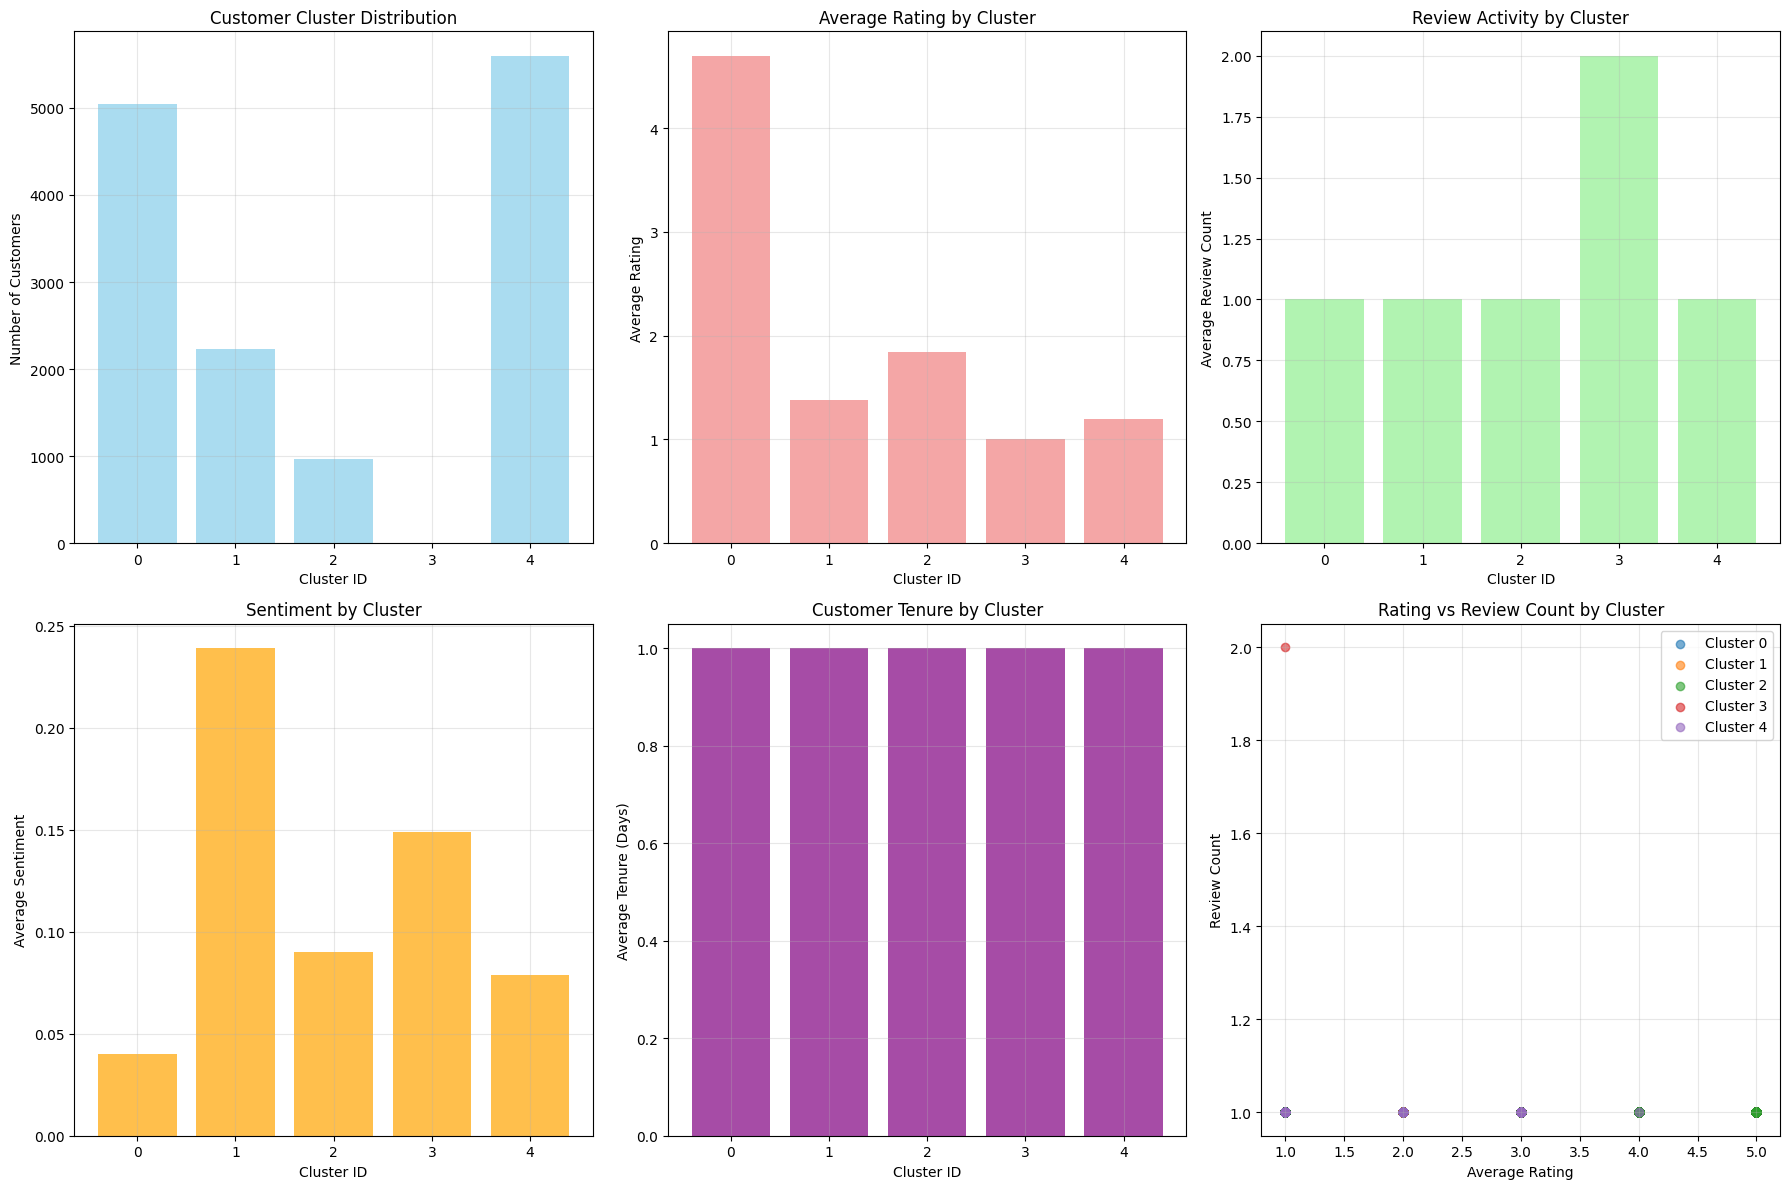

In [13]:
# =============================================================================
# Cell 12: Customer Cluster Visualization
# =============================================================================

print("\n" + "="*50)
print("CUSTOMER CLUSTER VISUALIZATION")
print("="*50)

# Create cluster visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Cluster distribution
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.7)
axes[0, 0].set_xlabel('Cluster ID')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Customer Cluster Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Average rating by cluster
cluster_ratings = customer_features.groupby('CustomerCluster')['avg_rating'].mean()
axes[0, 1].bar(cluster_ratings.index, cluster_ratings.values, color='lightcoral', alpha=0.7)
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_title('Average Rating by Cluster')
axes[0, 1].grid(True, alpha=0.3)

# Review count by cluster
cluster_review_counts = customer_features.groupby('CustomerCluster')['review_count'].mean()
axes[0, 2].bar(cluster_review_counts.index, cluster_review_counts.values, color='lightgreen', alpha=0.7)
axes[0, 2].set_xlabel('Cluster ID')
axes[0, 2].set_ylabel('Average Review Count')
axes[0, 2].set_title('Review Activity by Cluster')
axes[0, 2].grid(True, alpha=0.3)

# Sentiment by cluster
cluster_sentiment = customer_features.groupby('CustomerCluster')['avg_sentiment'].mean()
axes[1, 0].bar(cluster_sentiment.index, cluster_sentiment.values, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Average Sentiment')
axes[1, 0].set_title('Sentiment by Cluster')
axes[1, 0].grid(True, alpha=0.3)

# Tenure by cluster
cluster_tenure = customer_features.groupby('CustomerCluster')['tenure_days'].mean()
axes[1, 1].bar(cluster_tenure.index, cluster_tenure.values, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Average Tenure (Days)')
axes[1, 1].set_title('Customer Tenure by Cluster')
axes[1, 1].grid(True, alpha=0.3)

# Scatter plot: Rating vs Review Count
for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['CustomerCluster'] == cluster_id]
    axes[1, 2].scatter(cluster_data['avg_rating'], cluster_data['review_count'], 
                      alpha=0.6, label=f'Cluster {cluster_id}')

axes[1, 2].set_xlabel('Average Rating')
axes[1, 2].set_ylabel('Review Count')
axes[1, 2].set_title('Rating vs Review Count by Cluster')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# =============================================================================
# Cell 13: Linguistic Pattern Analysis
# =============================================================================

print("\n" + "="*50)
print("LINGUISTIC PATTERN ANALYSIS")
print("="*50)

# Analyze linguistic patterns for customer classification
def analyze_linguistic_patterns(text):
    """
    Analyze linguistic patterns in customer reviews
    This helps identify aggressive vs constructive reviewers
    """
    if pd.isna(text):
        return {'aggressive_words': 0, 'positive_words': 0, 'loyalty_words': 0}
    
    text_lower = text.lower()
    
    # Aggressive language indicators
    aggressive_words = ['terrible', 'awful', 'worst', 'horrible', 'hate', 'disgusting', 
                       'scam', 'fraud', 'never', 'disappointed', 'angry', 'furious']
    
    # Positive language indicators
    positive_words = ['excellent', 'amazing', 'love', 'perfect', 'wonderful', 'fantastic',
                     'great', 'good', 'satisfied', 'happy', 'recommend', 'pleased']
    
    # Loyalty indicators
    loyalty_words = ['regular', 'always', 'usually', 'frequent', 'again', 'return',
                    'loyal', 'customer', 'monthly', 'weekly']
    
    return {
        'aggressive_words': sum(1 for word in aggressive_words if word in text_lower),
        'positive_words': sum(1 for word in positive_words if word in text_lower),
        'loyalty_words': sum(1 for word in loyalty_words if word in text_lower)
    }

# Apply linguistic analysis
print("Analyzing linguistic patterns...")
linguistic_patterns = df['ReviewText'].apply(analyze_linguistic_patterns)
linguistic_df = pd.DataFrame(linguistic_patterns.tolist())

# Add to main dataframe
df = pd.concat([df, linguistic_df], axis=1)

# Aggregate by customer
customer_linguistic = df.groupby('UserId').agg({
    'aggressive_words': 'sum',
    'positive_words': 'sum',
    'loyalty_words': 'sum'
}).reset_index()

# Merge with customer features
customer_features = customer_features.merge(customer_linguistic, on='UserId', how='left')

print("Linguistic patterns analyzed successfully")


LINGUISTIC PATTERN ANALYSIS
Analyzing linguistic patterns...
Linguistic patterns analyzed successfully


In [15]:
# =============================================================================
# Cell 14: Customer Type Classification
# =============================================================================

print("\n" + "="*50)
print("CUSTOMER TYPE CLASSIFICATION")
print("="*50)

# Define customer types based on patterns
def classify_customer_type(row):
    """
    Classify customers based on their review patterns
    """
    if row['review_count'] >= 5 and row['avg_rating'] >= 4:
        return 'Loyal Customer'
    elif row['review_count'] >= 3 and row['avg_rating'] <= 2:
        return 'Chronic Complainer'
    elif row['aggressive_words'] > row['positive_words'] and row['avg_rating'] <= 2:
        return 'Aggressive Reviewer'
    elif row['positive_words'] > row['aggressive_words'] and row['avg_rating'] >= 4:
        return 'Positive Reviewer'
    elif row['review_count'] <= 2:
        return 'Occasional Reviewer'
    else:
        return 'Neutral Reviewer'

customer_features['CustomerType'] = customer_features.apply(classify_customer_type, axis=1)

# Distribution of customer types
customer_type_counts = customer_features['CustomerType'].value_counts()
print("Customer Type Distribution:")
print("-" * 30)
for customer_type, count in customer_type_counts.items():
    percentage = (count / len(customer_features)) * 100
    print(f"{customer_type}: {count:,} customers ({percentage:.1f}%)")


CUSTOMER TYPE CLASSIFICATION
Customer Type Distribution:
------------------------------
Occasional Reviewer: 9,768 customers (70.6%)
Positive Reviewer: 2,101 customers (15.2%)
Aggressive Reviewer: 1,970 customers (14.2%)


In [18]:
# =============================================================================
# Cell 15: Save Results
# =============================================================================

print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save topic modeling results
topic_results = {
    'lda_model': lda_model,
    'vectorizer': vectorizer,
    'topics': topics,
    'topic_labels': topic_labels,
    'df_with_topics': df[['UserId', 'ReviewText', 'ReviewRating', 'DominantTopic', 'TopicProbability']]
}

# Save customer classification results
customer_results = {
    'customer_features': customer_features,
    'kmeans_model': kmeans,
    'scaler': scaler,
    'cluster_interpretations': cluster_interpretations
}

with open('../src/models/topic_modeling_results.pkl', 'wb') as f:
    pickle.dump(topic_results, f)

with open('../src/models/customer_classification_results.pkl', 'wb') as f:
    pickle.dump(customer_results, f)

print("Results saved successfully!")
print("Files created:")
#print("- src/models/topic_modeling_results.pkl")
print("- src/models/customer_classification_results.pkl")


SAVING RESULTS
Results saved successfully!
Files created:
- src/models/customer_classification_results.pkl


In [ ]:
# =============================================================================
# Cell 16: Summary and Insights
# =============================================================================

print("\n" + "="*60)
print("SUMMARY AND KEY INSIGHTS")
print("="*60)

print("TOPIC MODELING INSIGHTS:")
print("-" * 25)
print(f"• Discovered {n_topics} main topics in customer reviews")
print(f"• Most common topics: {', '.join(topic_labels[:3])}")
print(f"• Topics with lowest ratings help identify problem areas")

print("\nCUSTOMER CLASSIFICATION INSIGHTS:")
print("-" * 35)
print(f"• Identified {optimal_k} distinct customer segments")
print(f"• {customer_type_counts.get('Loyal Customer', 0)} loyal customers found")
print(f"• {customer_type_counts.get('Chronic Complainer', 0)} chronic complainers identified")
print(f"• Linguistic patterns reveal customer satisfaction levels")




SUMMARY AND KEY INSIGHTS
TOPIC MODELING INSIGHTS:
-------------------------


NameError: name 'n_topics' is not defined